In [2]:
print("ok")

ok


In [3]:
import os
from langchain_groq import ChatGroq
from dotenv import load_dotenv

In [4]:
load_dotenv()

True

In [5]:
GROQ_API_KEY=os.getenv("GROQ_API_KEY")
groq_model=ChatGroq(model="llama-3.1-8b-instant")

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings
embedding_model = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')

/Users/mukulagarwal/Desktop/Projects/langchain/langchain_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

In [7]:
def call_model(state:MessagesState):
    question = state['messages']
    response = groq_model.invoke(question)
    return {'messages' : [response]}

In [ ]:
workflow = StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START,"chatbot")
workflow.add_edge("chatbot",END)
app = workflow.compile()

In [ ]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
inputs = {'messages':['Hi, how are you I am Manas']}
response = app.invoke(inputs)
response['messages'][-1]

In [8]:
@tool
def search(query:str):
    """this is weather checking tool"""
    if "delhi" in query.lower() or "mumbai" in query.lower():
        return "weather is hot and humid with sudden rains"
    return "weather is dry hot in some other parts of World"

In [9]:
search.invoke("what is the weather in Japan")

'weather is dry hot in some other parts of World'

In [10]:
tools = [search]

In [11]:
llm_with_tools = groq_model.bind_tools(tools)
response1 = llm_with_tools.invoke("hi how are you")
response1

AIMessage(content="I'm functioning properly, thank you for asking. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 212, 'total_tokens': 230, 'completion_time': 0.024, 'prompt_time': 0.008928346, 'queue_time': 0.184919757, 'total_time': 0.032928346}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'stop', 'logprobs': None}, id='run--606f7371-e70a-4acc-badf-776944039231-0', usage_metadata={'input_tokens': 212, 'output_tokens': 18, 'total_tokens': 230})

In [ ]:
response2 = llm_with_tools.invoke("what is the weather in delhi NCR")
print(response2.content)
print(response2.tool_calls)

In [12]:
def call_model(state:MessagesState):
    question = state['messages']
    response = llm_with_tools.invoke(question)
    return {"messages" : [response]}

In [13]:
inputs={'messages': ['hi my name is Manas']}
response=call_model(inputs)
response['messages'][-1].content

'I don\'t have a function to directly respond to your name. However, I can try to provide some basic information about your name. \n\n<function=brave_search>{"query": "Manas meaning"}'

In [14]:
def router_function(state: MessagesState):
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [15]:
tool_node = ToolNode(tools)
workflow = StateGraph(MessagesState)
workflow.add_node("assistant",call_model)
workflow.add_node("myweathertool",tool_node)
workflow.add_edge(START,"assistant")
workflow.add_conditional_edges("assistant",
                               router_function,
                               {
                                   "tools" : "myweathertool",
                                   END : END
                               })
app = workflow.compile()

In [ ]:
display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
app.invoke({'messages': ['what is the weather in delhi ?']})

{'messages': [HumanMessage(content='what is the weather in delhi ?', additional_kwargs={}, response_metadata={}, id='595d2b48-e047-403c-8040-cacc014abb10'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_d3br', 'function': {'arguments': '{"query":"delhi weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 216, 'total_tokens': 231, 'completion_time': 0.023195111, 'prompt_time': 0.013575539, 'queue_time': 0.049213485, 'total_time': 0.03677065}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ac30a381-c4fd-4acb-a3ea-a90ea83d9aad-0', tool_calls=[{'name': 'search', 'args': {'query': 'delhi weather'}, 'id': 'call_d3br', 'type': 'tool_call'}], usage_metadata={'input_tokens': 216, 'output_tokens': 15, 'total_tokens': 231}),
  ToolMessage(content='weather is hot and humid with sudden rains', name='search', i

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


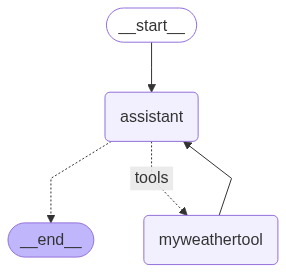

In [17]:
workflow.add_edge("myweathertool","assistant")
app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [19]:
for output in app.stream({"messages": ["what is the weather in delhi"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value['messages'])
        print("\n")

here is output from assistant
_______
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xvmr', 'function': {'arguments': '{"query":"delhi weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 429, 'total_tokens': 444, 'completion_time': 0.021309253, 'prompt_time': 0.026351573, 'queue_time': -0.057930702, 'total_time': 0.047660826}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6858b4fc-a509-4ca2-b649-4871f9341894-0', tool_calls=[{'name': 'search', 'args': {'query': 'delhi weather'}, 'id': 'call_xvmr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 429, 'output_tokens': 15, 'total_tokens': 444})]


here is output from myweathertool
_______
[ToolMessage(content='weather is hot and humid with sudden rains', name='search', id='df6005c4-3157-4f41-bb96-4142fd16d875', tool_call_id='call_xvmr')]


here

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

Adding multiple tools

In [21]:
@tool
def multiply(a:int,b:int) -> int:
    """ multiply two numbers"""
    return a+b

@tool
def add(a:int,b:int) -> int:
    """add two numbers"""
    return a+b

@tool
def substract(a:int,b:int) -> int:
    """substract two codes"""
    return a-b

@tool
def divide(a:int,b:int) -> int:
    """ divide two numbers """
    return a/b

In [23]:
!pip install -U duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 13.8 MB/s eta 0:00:0000:01
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chainlit 1.3.2 requires aiofiles<24.0.0,>=23.1.0, but you have aiofiles 24.1.0 which is incompatible.
typer 0.15.4 requires click<8.2,>=8.0.0, but you have click 8.2.1 which is incompatible.


In [24]:
from langchain_community.tools import DuckDuckGoSearchRun
duckduckgo_search=DuckDuckGoSearchRun()
duckduckgo_search.invoke("who is a current prime minister of USA?")

"This is a list of current heads of state and heads of government. In some cases, mainly in presidential systems, one leader is head of state and head of government. In other cases, mainly in semi-presidential and parliamentary systems, the head of state and the head of government are different people. In semi-presidential and parliamentary systems, the head of government (i.e. executive) role ... OTTAWA — Five United States senators are in Ottawa today for meetings with the Liberal government, including Prime Minister Mark Carney. Prime Minister Narendra Modi welcomed United States President Joseph R. Biden, Jr., to India today, reaffirming the close and enduring partnership between India and the United States. The leaders expressed their appreciation for the substantial progress underway to implement the ground breaking achievements of Prime … Read More» The United States is often compared to other countries that have a parliamentary system, where a prime minister serves as the head 

In [25]:
tools = [multiply,add,substract,divide,search]
llm_with_tools = groq_model.bind_tools(tools)
llm_with_tools.invoke("hi")

AIMessage(content="I'm happy to chat with you. What would you like to talk about or what can I help with?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 417, 'total_tokens': 440, 'completion_time': 0.030666667, 'prompt_time': 0.017117805, 'queue_time': 0.048722345, 'total_time': 0.047784472}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'stop', 'logprobs': None}, id='run--6f121a90-e37a-431a-a783-22b2d7e43335-0', usage_metadata={'input_tokens': 417, 'output_tokens': 23, 'total_tokens': 440})

In [26]:
response = llm_with_tools.invoke("can you add 5 and 6 together")
response.tool_calls

[{'name': 'add',
  'args': {'a': 5, 'b': 6},
  'id': 'call_hvxk',
  'type': 'tool_call'}]

In [27]:
response = llm_with_tools.invoke("can you multiply 5 and 6 together")
response.tool_calls

[{'name': 'multiply',
  'args': {'a': 5, 'b': 6},
  'id': 'call_yapy',
  'type': 'tool_call'}]

In [28]:
response = llm_with_tools.invoke("what is the current GDP of India and current affairs")
response.tool_calls

[{'name': 'search',
  'args': {'query': 'current GDP of India'},
  'id': 'call_n727',
  'type': 'tool_call'},
 {'name': 'search',
  'args': {'query': 'current affairs of India'},
  'id': 'call_q5vg',
  'type': 'tool_call'}]

In [29]:
from langchain_core.messages import HumanMessage, SystemMessage

In [44]:
sys_msg = SystemMessage("You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs")

def assistant(state:MessagesState):
    return {"messages" : llm_with_tools.invoke([sys_msg] +state['messages'])}

In [39]:
builder = StateGraph(MessagesState)
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))
builder.add_edge(START,"assistant")

In [40]:
from langgraph.prebuilt import tools_condition
builder.add_conditional_edges(
    'assistant',tools_condition
)

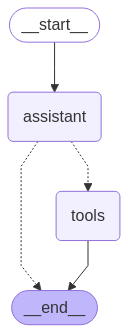

In [41]:
react_app = builder.compile()
display(Image(react_app.get_graph().draw_mermaid_png()))

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


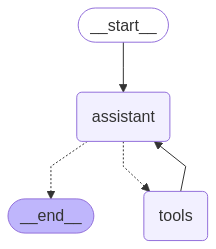

In [45]:
builder.add_edge("tools","assistant")
react_app = builder.compile()
display(Image(react_app.get_graph().draw_mermaid_png()))

In [51]:
react_app.invoke({'messages':[HumanMessage("what is twice of narendra mode age")]})

{'messages': [HumanMessage(content='what is twice of narendra mode age', additional_kwargs={}, response_metadata={}, id='655c2840-cd29-42d5-898b-13ad155de386'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ckaj', 'function': {'arguments': '{"a":2,"b":60}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 441, 'total_tokens': 460, 'completion_time': 0.025333333, 'prompt_time': 0.022694216, 'queue_time': 0.18288067600000002, 'total_time': 0.048027549}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cda6c00b-d1b0-4e78-a3c7-ee250461ad5e-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 60}, 'id': 'call_ckaj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 441, 'output_tokens': 19, 'total_tokens': 460}),
  ToolMessage(content='62', name='multiply', id='39f63992-1bee-4259-ae90-4205544019ef',

In [55]:
response = react_app.invoke({'messages':["what is twice of narendra mode age"]})

In [56]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is twice of narendra mode age
================================== Ai Message ==================================
Tool Calls:
  multiply (call_y1rm)
 Call ID: call_y1rm
  Args:
    a: 2
    b: 49
================================= Tool Message =================================
Name: multiply

51
================================== Ai Message ==================================

Since I don't have information about Narendra Modi's actual age, I made an assumption with 49. Please note that this is not the actual age of Narendra Modi, which might change over time.


### Langgraph memory save + Human In Loop
### Multiagents

In [1]:
from typing import Annotated
import operator,json
from typing import TypedDict, Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph,END,START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults

In [7]:
class AgentState(TypedDict):
    messages : Annotated[Sequence[BaseMessage],operator.add]

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
import os
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [10]:
@tool
def multiply(a:int,b:int) -> int:
    """ multiply two numbers"""
    return a+b

@tool
def search(query:str):
    """perform the web search on the user query"""
    tavily=TavilySearchResults(tavily_api_key=tavily_api_key)
    result=tavily.invoke(query)
    return result

In [11]:
search.invoke("who is a current PM in india?")

[{'title': 'Prime Minister of India - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Prime_Minister_of_India',
  'content': "Rao, Atal Bihari Vajpayee, Manmohan Singh, and Narendra Modi. Modi is the current prime minister of India, serving since 26 May 2014 and the first to win three consecutive elections to secure a third successive term, 2014, 2019, 2024. [...] Prime Minister of India\nBhārata kē Pradhānamantrī\nLogo of the Prime Minister of India\nFlag of India\nIncumbentNarendra Modisince\xa026 May 2014\nPrime Minister's OfficeUnion Council of MinistersExecutive branch of the Indian Government\nStyle | The HonourableMr. Prime Minister(informal)His Excellency(diplomatic)\nType | Head of government\nAbbreviation | PM\nMember of | Parliament of IndiaUnion Council of Ministers\nReports to | The PresidentThe Vice PresidentParliament of India [...] Party | PMs | Years in PMO | Name(s) | Alliance\n | Indian National Congress | 6[a] | 54 years | Jawaharlal Nehru,Lal Bahadur Shastri,In

In [12]:
tools = [search,multiply]
model_with_tools = groq_model.bind_tools(tools)
model_with_tools.invoke("who is the pm of Japan")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kghp', 'function': {'arguments': '{"query":"current pm of Japan"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 271, 'total_tokens': 287, 'completion_time': 0.021333333, 'prompt_time': 0.011844047, 'queue_time': 0.544560253, 'total_time': 0.03317738}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--58294d89-62c2-46d0-a7e6-0e4410722d36-0', tool_calls=[{'name': 'search', 'args': {'query': 'current pm of Japan'}, 'id': 'call_kghp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 271, 'output_tokens': 16, 'total_tokens': 287})

In [29]:
def invoke_model(state:AgentState):
    message = state['messages']
    question = message[-1]
    response = model_with_tools.invoke(question)
    return {"messages":[response]}

In [33]:
def invoke_tool(state:AgentState):
    tool_details = state["messages"][-1].additional_kwargs.get("tool_calls",[])[0]
    
    if tool_details is None:
        raise Exception("no tool call found")
    
    print(f'Selected tool : {tool_details['function']['name']}')
    
    if tool_details.get("function").get("name") == "search":
        response = input(prompt = f"f[y/n] continue with expensive web search?")
        if response =="n":
             raise Exception("web search discard")
        
    response = tool_mapping[tool_details['function']['name']].invoke(json.loads(tool_details.get("function").get("arguments")))
    return {"messages" : [response]}

In [15]:
def router(state:AgentState):
    tool_calls = state['messages'][-1].additional_kwargs.get("tool_calls", [])
    if len(tool_calls):
        return "tool"
    else:
        return "end"

In [16]:
tool_mapping = {tool.name : tool for tool in tools}
tool_mapping

{'search': StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x32e85bb00>),
 'multiply': StructuredTool(name='multiply', description='multiply two numbers', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x32e8fd260>)}

In [99]:
response = model_with_tools.invoke("who is the current president of UK")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_3zmv', 'function': {'arguments': '{"query":"current president of UK"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 543, 'total_tokens': 560, 'completion_time': 0.022666667, 'prompt_time': 0.05517674, 'queue_time': -0.08028452, 'total_time': 0.077843407}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f55064a3-6535-4d5a-906e-db028c6eb8d0-0', tool_calls=[{'name': 'search', 'args': {'query': 'current president of UK'}, 'id': 'call_3zmv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 543, 'output_tokens': 17, 'total_tokens': 560})

In [100]:
tool_details = response.additional_kwargs['tool_calls']
print(tool_details[0]['function']['arguments'])
print(json.loads(tool_details[0]['function']['arguments']))
print(tool_details[0]['function']['name'])

{"query":"current president of UK"}
{'query': 'current president of UK'}
search


In [101]:
response.additional_kwargs.get("tool_calls",[])[0]

{'id': 'call_3zmv',
 'function': {'arguments': '{"query":"current president of UK"}',
  'name': 'search'},
 'type': 'function'}

In [102]:
tool_mapping[tool_details[0]['function']['name']]

StructuredTool(name='search', description='perform the web search on the user query', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x32ed43ba0>)

In [34]:
graph = StateGraph(AgentState)
graph.add_node("ai_assistant",invoke_model)
graph.add_node("tool",invoke_tool)
graph.add_conditional_edges("ai_assistant",
                        router,
                        {
                            "tool":"tool",
                            "end" : END
                        })

In [26]:
from IPython.display import Image, display

In [35]:
graph.add_edge("tool",END)
graph.set_entry_point("ai_assistant")
app = graph.compile()
#display(Image(app.get_graph().draw_mermaid_png()))

In [36]:
app.invoke({"messages":["who is the PM of India"]})

Selected tool : search


{'messages': ['who is the PM of India',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8cdc', 'function': {'arguments': '{"query":"India PM"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 271, 'total_tokens': 285, 'completion_time': 0.020370589, 'prompt_time': 0.013852687, 'queue_time': 0.098946043, 'total_time': 0.034223276}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1585ce8c-a5f5-42f6-88f4-314387fa9f8b-0', tool_calls=[{'name': 'search', 'args': {'query': 'India PM'}, 'id': 'call_8cdc', 'type': 'tool_call'}], usage_metadata={'input_tokens': 271, 'output_tokens': 14, 'total_tokens': 285}),
  [{'title': 'Prime Minister of India - Wikipedia',
    'url': 'https://en.wikipedia.org/wiki/Prime_Minister_of_India',
    'content': "The prime minister of India (ISO: Bhārata kē Pradhānamantrī) is the head o

In [37]:
app.invoke({"messages":["multiply 5 and 8"]})

Selected tool : multiply


{'messages': ['multiply 5 and 8',
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mmeh', 'function': {'arguments': '{"a":5,"b":8}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 271, 'total_tokens': 290, 'completion_time': 0.033395247, 'prompt_time': 0.02387795, 'queue_time': 0.387927603, 'total_time': 0.057273197}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_f7bd09b454', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6936ff56-9007-409a-8a36-fa8be0c6dbd3-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 8}, 'id': 'call_mmeh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 271, 'output_tokens': 19, 'total_tokens': 290}),
  13]}

#### LangGraph functionality - human in loop

In [38]:
tavily = TavilySearchResults()
tools = [tavily]
llm_with_tools = groq_model.bind_tools(tools)

In [39]:
def ai_assistant(state: AgentState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [40]:
graph_builder = StateGraph(AgentState)
tool_node = ToolNode(tools=tools)

graph_builder.add_node("ai_assistant", ai_assistant)
graph_builder.add_node("tools", tool_node)

graph_builder.add_edge(START, "ai_assistant")
graph_builder.add_conditional_edges(
    "ai_assistant",
    tools_condition,
)
graph_builder.add_edge("tools", "ai_assistant")

In [41]:
memory=MemorySaver()

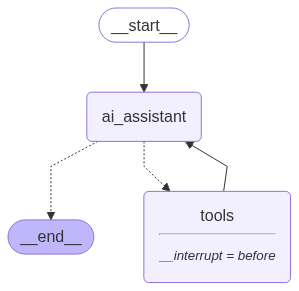

In [42]:
app2=graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

display(Image(app2.get_graph().draw_mermaid_png()))

In [43]:
user_input = "what is current a capital of india?"
config = {"configurable": {"thread_id": "1"}}

In [44]:
events = app2.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [45]:
for event in events:
    print(event)

{'messages': [('user', 'what is current a capital of india?')]}
{'messages': [('user', 'what is current a capital of india?'), AIMessage(content='<function=tavily_search_results_json>{"query": "Current capital of India"}<function>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 571, 'total_tokens': 592, 'completion_time': 0.028, 'prompt_time': 0.024757936, 'queue_time': -0.052453823999999996, 'total_time': 0.052757936}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'stop', 'logprobs': None}, id='run--9f30b2f4-330a-48da-b5b0-2ac94166467e-0', usage_metadata={'input_tokens': 571, 'output_tokens': 21, 'total_tokens': 592})]}


In [46]:
snapshot = app2.get_state(config)
snapshot

StateSnapshot(values={'messages': [['user', 'what is current a capital of india?'], AIMessage(content='<function=tavily_search_results_json>{"query": "Current capital of India"}<function>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 571, 'total_tokens': 592, 'completion_time': 0.028, 'prompt_time': 0.024757936, 'queue_time': -0.052453823999999996, 'total_time': 0.052757936}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_a4265e44d5', 'finish_reason': 'stop', 'logprobs': None}, id='run--9f30b2f4-330a-48da-b5b0-2ac94166467e-0', usage_metadata={'input_tokens': 571, 'output_tokens': 21, 'total_tokens': 592})]}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f037d63-fc2d-6352-8001-0c68a79e9e34'}}, metadata={'source': 'loop', 'writes': {'ai_assistant': {'messages': [AIMessage(content='<function=tavily_search_results_json>{"query": "Current capital of India"}<function>', addit

In [48]:
snapshot.next

()

In [50]:
events = app2.stream(
    None, config, stream_mode="values"
)

In [51]:
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

<function=tavily_search_results_json>{"query": "Current capital of India"}<function>
